In [13]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import numpy as np



In [14]:
cleaned_df = pd.read_csv('../data/cleaned_tweet_data.csv')
cleaned_df.head()
#cleaned_df = cleaned_df.fillna("")

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,clean_text
0,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,43.0,43.0,davideiacovozzi,18.0,55.0,NaN,"['gold', 'silver', 'crypto']","[{'screen_name': 'NorthstarCharts', 'name': 'N...",NaN,the 10year yield is telling us that theres a ...
1,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175000,en,32.0,32.0,davideiacovozzi,18.0,55.0,NaN,[],"[{'screen_name': 'MichaelAArouet', 'name': 'Mi...",NaN,german 10y mortgage rate went from 08 to 250 ...
2,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,26.0,26.0,davideiacovozzi,18.0,55.0,False,[],"[{'screen_name': 'goldseek', 'name': 'Peter ⚒ ...",NaN,when
3,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,213.0,213.0,davideiacovozzi,18.0,55.0,NaN,[],"[{'screen_name': 'charliebilello', 'name': 'Ch...",NaN,the 30year mortgage rate in the us rises to 5...
4,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,417.0,417.0,davideiacovozzi,18.0,55.0,False,[],"[{'screen_name': 'biancoresearch', 'name': 'Ji...",NaN,rates rise until something breaks … is anythi...


In [16]:
def text_category(p: float) -> str:
    if p > 0:
        return "positive"
    elif p == 0:
        return "neutral"
    else:
        return "negative"

In [17]:
cleaned_df['polarity'] = cleaned_df['polarity'].apply(pd.to_numeric)
cleaned_df['score'] = cleaned_df['polarity'].apply(text_category)
cleaned_df['score'].value_counts()

neutral     7422
positive    6278
negative    2685
Name: score, dtype: int64

### Sentiment Analysis

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

### Plot distribution of data

<AxesSubplot:title={'center':'score'}>

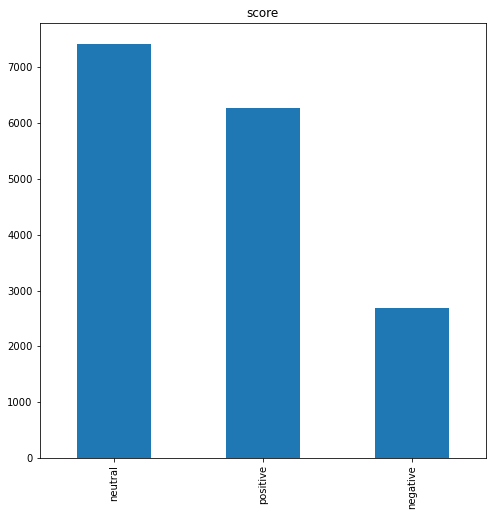

In [19]:
score_count =  cleaned_df['score'].value_counts()
score_count.plot(kind="bar", y="score", title="score", figsize=[8, 8])

In [20]:
def remove_neutral(value):
    return value != "neutral"

### Convert words in text to their root form

In [21]:
stemmer = PorterStemmer()
def stem_word(text: str) -> str:
    
    stemmed_words = []
    sent_list = text.split()
    
    for word in sent_list:
        try:
            stemmed_words.append(stemmer.stem(word)) 
        except:
             stemmed_words.append(word)
    return ' '.join(stemmed_words)

In [24]:
cleaned_df = cleaned_df.astype({"clean_text": str})
cleanedTweet = cleaned_df[cleaned_df['score'].map(remove_neutral)]
cleanedTweet['score'] = cleanedTweet["score"].map( lambda score: 1 if score == "positive" else 0)
cleanedTweet['clean_text'] = cleanedTweet['clean_text'].apply(stem_word)

/tmp/ipykernel_145752/2381445955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedTweet['score'] = cleanedTweet["score"].map( lambda score: 1 if score == "positive" else 0)
/tmp/ipykernel_145752/2381445955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedTweet['clean_text'] = cleanedTweet['clean_text'].apply(stem_word)


In [25]:
(X, y) = cleanedTweet['clean_text'], cleanedTweet['score']

In [26]:
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_vectorizer.fit(X.values)

CountVectorizer(ngram_range=(3, 3))

In [27]:
X_trigram = trigram_vectorizer.transform(X.values)

In [28]:
trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(X_trigram)

TfidfTransformer()

In [29]:
X_train_tf_idf = trigram_tf_idf_transformer.transform(X_trigram)

### Model training
* Set train to validation split to 75/25

In [30]:
def train_and_show_scores(X, y, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [31]:
train_and_show_scores(X_trigram, y, title="trigram")

trigram
Train score: 0.99 ; Validation score: 0.77



In [32]:
train_and_show_scores(X_train_tf_idf, y, title="trigram_tf_idf")

trigram_tf_idf
Train score: 0.99 ; Validation score: 0.77



We can see from the result above that when using the CountVectorizer and TF-IDF we are getting the same result. Even though TF-IDF is a better vectorizer that CountVectorizer we are getting the same result using this data. We can remove the stop words from the data and test if we get a different result

### Topic Modeling

In [33]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re

In [34]:
#data loader class
class DataLoader:
  def __init__(self,dir_name,file_name):
    self.dir_name=dir_name
    self.file_name = file_name
    
 
  def read_csv(self):
    os.chdir(self.dir_name)
    tweets_df=pd.read_csv(self.file_name)
    return tweets_df

In [36]:
DataLoader_obj= DataLoader('../data/','cleaned_tweet_data.csv')
tweets_df = DataLoader_obj.read_csv()

In [37]:
tweets_df.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,clean_text
0,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,43.0,43.0,davideiacovozzi,18.0,55.0,NaN,"['gold', 'silver', 'crypto']","[{'screen_name': 'NorthstarCharts', 'name': 'N...",NaN,the 10year yield is telling us that theres a ...
1,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175000,en,32.0,32.0,davideiacovozzi,18.0,55.0,NaN,[],"[{'screen_name': 'MichaelAArouet', 'name': 'Mi...",NaN,german 10y mortgage rate went from 08 to 250 ...
2,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,26.0,26.0,davideiacovozzi,18.0,55.0,False,[],"[{'screen_name': 'goldseek', 'name': 'Peter ⚒ ...",NaN,when
3,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,213.0,213.0,davideiacovozzi,18.0,55.0,NaN,[],"[{'screen_name': 'charliebilello', 'name': 'Ch...",NaN,the 30year mortgage rate in the us rises to 5...
4,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,417.0,417.0,davideiacovozzi,18.0,55.0,False,[],"[{'screen_name': 'biancoresearch', 'name': 'Ji...",NaN,rates rise until something breaks … is anythi...


In [39]:
tweets_df.dropna()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,clean_text
43,2022-04-22 22:32:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",MICKEY’S BAD MOVE: @GovRonDeSantis has now sig...,-0.037500,0.533333,en,0.0,0.0,MercuryReports,9254.0,9422.0,False,[],"[{'screen_name': 'GovRonDeSantis', 'name': 'Ro...",All Over America,mickey’s bad move has now signed the bill tha...
44,2022-04-22 22:16:55+00:00,"<a href=""http://twitter.com/download/iphone"" r...",ELECTIONS HAVE CONSEQUENCES: Biden’s historic ...,-0.066667,0.033333,en,0.0,0.0,MercuryReports,9254.0,9422.0,False,[],[],All Over America,elections have consequences biden’s historic m...
45,2022-04-22 07:15:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...",COINCIDENCE? 18 U.S. food processing facilitie...,-0.077778,0.177778,en,1.0,1.0,MercuryReports,9254.0,9422.0,False,[],[],All Over America,coincidence 18 us food processing facilities b...
46,2022-04-22 07:11:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",FOOD PROCESSING PLANTS BEING DESTROYED: “A Sma...,-0.100000,0.450000,en,2.0,2.0,MercuryReports,9254.0,9422.0,False,[],[],All Over America,food processing plants being destroyed “a smal...
48,2022-04-21 22:22:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",DISGUSTING HUMAN BEING: What one person calls ...,-0.500000,0.550000,en,0.0,0.0,MercuryReports,9254.0,9422.0,False,[],[],All Over America,disgusting human being what one person calls h...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16244,2022-04-22 14:00:54+00:00,"<a href=""https://www.twitter.com/"" rel=""nofoll...",#TopNews Stories Of This Hour\n#Headlines #Zee...,0.000000,0.000000,en,0.0,0.0,Zee24Kalak,212228.0,187.0,False,"['TopNews', 'Headlines', 'ZeeNews']",[],India,stories of this hour\n
16350,2022-04-22 13:52:56+00:00,"<a href=""http://twitter.com/download/android"" ...","RT @nitinagarwalINC: Love is strength, \nHate...",-0.150000,0.750000,en,110.0,110.0,ibrahimpatel007,4684.0,1225.0,False,['IndiaAgainstHate'],"[{'screen_name': 'nitinagarwalINC', 'name': 'N...","Hyderabad, India",love is strength \nhate is weakness\n\n sh ...
16357,2022-04-22 13:38:49+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @drshamamohd: Zoya Charitable Trust distrib...,0.600000,0.800000,en,131.0,131.0,ibrahimpatel007,4684.0,1225.0,False,[],"[{'screen_name': 'drshamamohd', 'name': 'Dr. S...","Hyderabad, India",zoya charitable trust distributed ramadan kit...
16358,2022-04-22 13:38:43+00:00,"<a href=""http://twitter.com/download/android"" ...","RT @SpiritOfCongres: It's not a meeting, it's ...",0.000000,0.000000,en,51.0,51.0,ibrahimpatel007,4684.0,1225.0,False,[],"[{'screen_name': 'SpiritOfCongres', 'name': 'S...","Hyderabad, India",its not a meeting its a movement


In [40]:
len(tweets_df)

16385

In [38]:
class PrepareData:
  def __init__(self,df):
    self.df=df
    
  def preprocess_data(self):
    tweets_df = self.df.loc[self.df['lang'] =="en"]

    
    #text Preprocessing
    tweets_df['clean_text']=tweets_df['clean_text'].astype(str)
    tweets_df['clean_text'] = tweets_df['clean_text'].apply(lambda x: x.lower())
    tweets_df['clean_text']= tweets_df['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
    
    #Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['clean_text']]
    word_list = [sent.split() for sent in sentence_list]

    #Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(word_list)
    corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]



    
    return word_list, word_to_id, corpus_1


In [41]:
PrepareData_obj=PrepareData(tweets_df)
word_list ,id2word,corpus=PrepareData_obj.preprocess_data()

### Building LDA Model

In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [43]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('back', 0.02048943),
   ('10', 0.018056605),
   ('go', 0.016158711),
   ('after', 0.016064364),
   ('sri', 0.015582654),
   ('levels', 0.009912592),
   ('which', 0.009667392),
   ('lanka', 0.009445169),
   ('going', 0.008866017),
   ('she', 0.008775503)]),
 (1,
  [('so', 0.015950788),
   ('online', 0.015102598),
   ('two', 0.011658563),
   ('police', 0.011064114),
   ('2', 0.010711042),
   ('while', 0.010462837),
   ('president', 0.008853068),
   ('against', 0.0078541),
   ('twitter', 0.0075071636),
   ('days', 0.007370046)]),
 (2,
  [('the', 0.065834634),
   ('to', 0.043365154),
   ('of', 0.035203803),
   ('in', 0.031604063),
   ('a', 0.027775384),
   ('and', 0.023927564),
   ('is', 0.02345015),
   ('for', 0.021295615),
   ('on', 0.017287998),
   ('…', 0.016984498)]),
 (3,
  [('amp', 0.027725324),
   ('our', 0.02133741),
   ('what', 0.01966301),
   ('they', 0.019000499),
   ('your', 0.016952934),
   ('but', 0.016356388),
   ('just', 0.012931148),
   ('his', 0.012394483),
   (

### Model Analysis

In [44]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -8.616583161375791

 Ldamodel Coherence Score/Accuracy on Tweets:  0.3492175328558506


In [45]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/home/teddy/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/teddy/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/teddy/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/teddy/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/teddy/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.381688 -0.000980       1        1  62.752062
3      0.094225  0.255951       2        1  12.721023
0      0.096802 -0.102668       3        1   8.560644
4      0.096184 -0.095700       4        1   8.313053
1      0.094477 -0.056602       5        1   7.653219, topic_info=        Term         Freq        Total Category  logprob  loglift
12       the  9772.000000  9772.000000  Default  30.0000  30.0000
32        to  6437.000000  6437.000000  Default  29.0000  29.0000
6         of  5225.000000  5225.000000  Default  28.0000  28.0000
4         in  4691.000000  4691.000000  Default  27.0000  27.0000
1          a  4123.000000  4123.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
958      top    73.720731    74.489327   Topic5  -5.5035   2.5597
1983   daily    74.697256    75.482500   Topic5  -5.4903   2.5596
887   russia    71.833085    72.602668   Topic5  -5.5294   2.5594
1422   party    70.022481    70.789059   Topic5  -5.5550   2.5592
6341     imf    74.271818    75.089250   Topic5  -5.4961   2.5591

[185 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1800      5  0.992936      1
279       3  0.998783     10
1169      4  0.997912    100
1592      5  0.996617      2
984       4  0.992603   2022
...     ...       ...    ...
34        1  0.999658    you
525       2  0.998370   your
16        1  0.999724      …
1982      4  0.990821      🚀
7195      3  0.996121  🟩🟩🟩🟩🟩

[159 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])